# Projet 5 - Catégorisez automatiquement des questions

## Partie 2 -- Apprentissage

### Espace de bibliothèques

In [81]:
import IPython.display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sb
import gensim
import warnings

from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models

import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.preprocessing import MultiLabelBinarizer

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import jaccard_score


import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=VisibleDeprecationWarning)

### Espace de fonctions

In [82]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True)
        final.append(new)
    return final

In [83]:
def predict_unsupervised_tags(text):
    
    corpus_new = id2word.doc2bow(text)
    topics = lda_model.get_document_topics(corpus_new)
    
    relevant_topic = topics[0][0]
    relevant_topic_prob = topics[0][1]
    
    for i in range(len(topics)):
        if topics[i][1] > relevant_topic_prob:
            relevant_topic = topics[i][0]
            relevant_topic_prob = topics[i][1]
            
    potential_tags = lda_model.get_topic_terms(topicid=relevant_topic, topn=30)    
    relevant_tags = [id2word[tag[0]] for tag in potential_tags if id2word[tag[0]] in text]
    
    return relevant_tags

In [84]:
def predict_supervised_tags(n,y_test,y_pred):
    for i in range(n):
        print("Prédit : ", multilabel_binarizer.inverse_transform(y_pred)[i])
        print("Valeur réelle : ", multilabel_binarizer.inverse_transform(y_test)[i])
        print()

In [85]:
def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigram(texts):
    return([trigram[bigram[doc]] for doc in texts])

In [86]:
def gen_model(cor,id2,num_top):
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus = cor,
                                           id2word = id2,
                                           num_topics = num_top,
                                           random_state = 42,
                                           #update_every = 1,
                                           chunksize = 100,
                                           passes = 10)#,
                                           #alpha  = "auto")
    return lda_model

In [87]:
def gen_corpus(d_words):
    corpus = []
    for text in d_words:
        new = id2word.doc2bow(text)
        corpus.append(new)
    return corpus

In [88]:
def lda_vis(lda, cor,id2):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda,cor,id2,mds = "PCoA",R=10)
    return vis

In [89]:
%%time
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par thèmes réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des questions par clusters')
    
    plt.show()
    print("ARI : ", ARI)


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.8 µs


### Lecture du fichier

In [90]:
df_clean = pd.read_csv("/home/fayz/Documents/OpenClassrooms/Projet5/df_clean.csv")

In [91]:
df_clean['sentence_title_bow'][4]

"element visible error able click element want click radio button appears webpage code follow strong html code strong pre code div class= small checkbox red theme raleway regular text muted2 position relative div class= city checkbox inline block position relative class= 'rounded checkbox main.current_city_id 'mb main.ifdeviceisphone label class= mdl radio mdl radio mdl ripple effect for= mumbaicity class= 'is checked main.current_city_id input type= radio id= mumbaicity class= mdl radio__button position relative vertical middle name= city value= click= main.setcity 'mumbai span class= mdl radio__label position relative font15 img class= city icon src= assets img cities mumbai icon.png mumbai span label div div code pre strong tesstcase strong pre code demo test.js describe 'protractor demo app function jasmine.default_timeout_interval 10000000 'check item count function browser.get link element by.id 'mumbaicity .click code pre this test throughs error blockquote protractor demo app c

In [92]:
df_clean['Tags'][4]

'<javascript><angularjs><selenium><selenium-webdriver><protractor>'

In [11]:
df_clean.head()

,Title,Tags,sentence_title_bow,ViewCount
0,Print array without brackets and commas,<java><android><arrays><list><collections>,print array without brackets commas porting ha...,192840
1,"Allen Holub wrote ""You should never use get/se...",<language-agnostic><oop><immutability><setter>...,allen holub wrote you never use get set functi...,9946
2,How do you get a directory listing in C?,<c><file><directory><cross-platform><common-ta...,how get directory listing how scan directory f...,138108
3,Returning DataTables in WCF/.NET,<c#><.net><wcf><web-services><datatable>,returning datatables wcf .net wcf service want...,56351
4,Element not visible error (not able to click a...,<javascript><angularjs><selenium><selenium-web...,element visible error able click element want ...,44978


# 1. Approche non supervisée

## 1.1 Modélisation des topics - Utilisation du corps des textes pour l'apprentissage

## Découpage du jeu de données

In [73]:
X = df_clean.copy()
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 20)
X_train = X_train.sort_index()

### 1.1.1 Score de cohérence

In [74]:
data_words = gen_words(X_train["sentence_title_bow"])

In [77]:
id2word = corpora.Dictionary(data_words)

In [15]:
corpus = gen_corpus(data_words)

In [16]:
%%time
coh_score = []
for i in range(2,15):
    lda_model = gen_model(corpus,id2word,i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh_score.append(coherence_lda)
    print("Nombre de clusters : ", i)
    print("Score de cohérence : ", round(coherence_lda,3))

Nombre de clusters :  2
Score de cohérence :  0.407
Nombre de clusters :  3
Score de cohérence :  0.428
Nombre de clusters :  4
Score de cohérence :  0.446
Nombre de clusters :  5
Score de cohérence :  0.476
Nombre de clusters :  6
Score de cohérence :  0.475
Nombre de clusters :  7
Score de cohérence :  0.471
Nombre de clusters :  8
Score de cohérence :  0.451
Nombre de clusters :  9
Score de cohérence :  0.481
Nombre de clusters :  10
Score de cohérence :  0.491
Nombre de clusters :  11
Score de cohérence :  0.473
Nombre de clusters :  12
Score de cohérence :  0.47
Nombre de clusters :  13
Score de cohérence :  0.499
Nombre de clusters :  14
Score de cohérence :  0.471
CPU times: user 4min 3s, sys: 1min 31s, total: 5min 35s
Wall time: 5min 17s


### 1.1.2 Modèle retenu

In [17]:
%%time
lda_model = gen_model(corpus,id2word,coh_score.index(max(coh_score))+2)

CPU times: user 26.2 s, sys: 10.1 s, total: 36.3 s
Wall time: 31.5 s


In [18]:
%%time
lda_vis(lda_model,corpus,id2word)

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dis

CPU times: user 5.19 s, sys: 1.51 s, total: 6.7 s
Wall time: 7.34 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.059643  0.056240       1        1  15.708614
0     -0.119570 -0.088932       2        1  13.376258
6      0.043802  0.121733       3        1   9.392191
4      0.011093 -0.103163       4        1   9.312709
11    -0.051764  0.064786       5        1   9.245516
12    -0.124074  0.054014       6        1   8.609535
9      0.015894 -0.048046       7        1   5.853943
5     -0.128393 -0.065002       8        1   5.835629
7      0.062671 -0.001610       9        1   5.635160
8      0.026695  0.220914      10        1   5.589936
2      0.249199 -0.021268      11        1   5.246574
10     0.144899 -0.106255      12        1   3.274045
3     -0.070809 -0.083410      13        1   2.919888, topic_info=         Term           Freq          Total Category  logprob  loglift
530      quot   13115.000000   13115.000000  Default  10.0000  10.0000
11       code  149413.000000  149413.000000  Default   9.0000   9.0000
2     android   12480.000000   12480.000000  Default   8.0000   8.0000
32       java   10742.000000   10742.000000  Default   7.0000   7.0000
382       org    8763.000000    8763.000000  Default   6.0000   6.0000
...       ...            ...            ...      ...      ...      ...
213      data    1160.499061   12051.988387  Topic13  -4.2706   1.1932
1565    mysql     621.605168    1436.882706  Topic13  -4.8949   2.6957
35       like     737.325065   13183.874546  Topic13  -4.7242   0.6499
43        pre     827.505755   52995.361736  Topic13  -4.6088  -0.6259
11       code     813.352247  149413.790217  Topic13  -4.6261  -1.6797

[406 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
68         1  0.102873  access
68         2  0.111088  access
68         3  0.031433  access
68         4  0.053222  access
68         5  0.028933  access
...      ...       ...     ...
24948      1  0.997515     xmm
2427       9  0.984216     xor
11631      2  0.010982      xx
11631      3  0.027454      xx
11631      5  0.960890      xx

[2422 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 7, 5, 12, 13, 10, 6, 8, 9, 3, 11, 4])

### 1.1.3 Test sur le jeu de test

In [19]:
data_words_test = gen_words(X_test.reset_index()["sentence_title_bow"])

In [20]:
for i in range(10):
    print(predict_unsupervised_tags(data_words_test[i])[:5])
    print(gen_words(X_test.reset_index()["Tags"])[i])
    print()

['code', 'pre', 'using', 'get', 'want']
['javascript', 'node', 'js', 'express', 'middleware', 'next']

['code', 'href', 'rel', 'noreferrer', 'width']
['css', 'text', 'overflow', 'center', 'alignment']

['video', 'iphone']
['iphone', 'objective', 'ios', 'video', 'opengl', 'es']

['code', 'pre', 'class', 'div', 'data']
['javascript', 'jquery', 'html', 'css', 'twitter', 'bootstrap']

['href', 'com', 'using', 'html', 'the']
['android', 'performance', 'sqlite', 'ormlite', 'greendao']

['code', 'pre', 'var', 'get', 'strong']
['javascript', 'debugging', 'logging', 'console', 'console', 'log']

['code', 'pre', 'strong', 'windows', 'files']
['python', 'django', 'virtualenv', 'cloud', 'hosting', 'paas']

['code', 'pre', 'int', 'like', 'using']
['python', 'pandas', 'dataframe', 'merge', 'left', 'join']

['code', 'static', 'the', 'one']
['java', 'interface', 'static', 'final', 'language', 'implementation']

['code', 'pre', 'string', 'strong', 'public']
['java', 'hibernate', 'jpa', 'spring', 'data'

Utilisation du mot "code" pour quasiment tous les cluster prédit
On ne retrouve, visuellement, pas assez de mots clés déjà entré par les utilisateurs.
Ce modèle ne semble pas performant, mais suggère des mots clés

## 1.2 Modélisation des topics - Utilisation des bigrammes et trigrammes des textes pour l'apprentissage

#### Bigrames et trigrames

In [21]:
%%time
bigrams_phrases = gensim.models.Phrases(data_words, min_count = 5, threshold=50)
trigram_phrases = gensim.models.Phrases(bigrams_phrases[data_words], threshold=50)

bigram = gensim.models.phrases.Phraser(bigrams_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigram(data_bigrams)

CPU times: user 11.1 s, sys: 0 ns, total: 11.1 s
Wall time: 11.1 s


In [22]:
%%time
id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]

CPU times: user 1.41 s, sys: 21.4 ms, total: 1.43 s
Wall time: 1.43 s


In [23]:
%%time
tfidf = TfidfModel(corpus, id2word = id2word)
low_value = 0.01
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i] = new_bow

CPU times: user 2.43 s, sys: 0 ns, total: 2.43 s
Wall time: 2.43 s


### 1.2.1 Score de cohérence

In [24]:
%%time
coh_score = []
for i in range(2,10):
    lda_model = gen_model(corpus,id2word,i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh_score.append(coherence_lda)
    print("Nombre de clusters : ", i)
    print("Score de cohérence : ", coherence_lda)

Nombre de clusters :  2
Score de cohérence :  0.3506237286879659
Nombre de clusters :  3
Score de cohérence :  0.3542658060226081
Nombre de clusters :  4
Score de cohérence :  0.3882491910181172
Nombre de clusters :  5
Score de cohérence :  0.4280123651674641
Nombre de clusters :  6
Score de cohérence :  0.4336308029898253
Nombre de clusters :  7
Score de cohérence :  0.4136328445463001
Nombre de clusters :  8
Score de cohérence :  0.44300363608146426
Nombre de clusters :  9
Score de cohérence :  0.463456453339523
CPU times: user 2min 16s, sys: 47.1 s, total: 3min 3s
Wall time: 2min 52s


In [25]:
%%time
coh_score = []
a = 30
for i in range(a,40):
    lda_model = gen_model(corpus,id2word,i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_bigrams_trigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh_score.append(coherence_lda)
    print("Nombre de clusters : ", i)
    print("Score de cohérence : ", coherence_lda)

Nombre de clusters :  30
Score de cohérence :  0.46441062420248097
Nombre de clusters :  31
Score de cohérence :  0.44883020608943486
Nombre de clusters :  32
Score de cohérence :  0.4542991748238439
Nombre de clusters :  33
Score de cohérence :  0.43274225573117203
Nombre de clusters :  34
Score de cohérence :  0.4381932996489009
Nombre de clusters :  35
Score de cohérence :  0.4504505132128042
Nombre de clusters :  36
Score de cohérence :  0.4297423145666446
Nombre de clusters :  37
Score de cohérence :  0.421920516862071
Nombre de clusters :  38
Score de cohérence :  0.43179807915325
Nombre de clusters :  39
Score de cohérence :  0.418709329443943
CPU times: user 10min 50s, sys: 2min 59s, total: 13min 50s
Wall time: 20min 21s


### 1.2.2 Modèle retenu

In [26]:
%%time
lda_model = gen_model(corpus,id2word,coh_score.index(max(coh_score))+a)

CPU times: user 58.8 s, sys: 18.5 s, total: 1min 17s
Wall time: 1min 21s


In [27]:
%%time
lda_vis(lda_model,corpus,id2word)

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dis

CPU times: user 15.9 s, sys: 34.4 s, total: 50.3 s
Wall time: 11 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
26    -0.152175 -0.083268       1        1  16.103628
23    -0.173878  0.144328       2        1   9.695759
29    -0.125630 -0.069267       3        1   7.462233
27    -0.163693  0.114227       4        1   6.624584
7     -0.096008 -0.099820       5        1   6.013197
4     -0.130143  0.121557       6        1   4.448284
13    -0.085703 -0.150969       7        1   4.166148
3     -0.034240 -0.185117       8        1   4.034884
24    -0.113642  0.056217       9        1   3.752302
14    -0.109172 -0.058906      10        1   3.037061
0     -0.031081  0.037634      11        1   2.974971
6     -0.035673 -0.036372      12        1   2.950053
15    -0.079639 -0.042843      13        1   2.868631
8      0.077493 -0.188279      14        1   2.713722
2     -0.038223 -0.002032      15        1   2.624922
17     0.027926 -0.104692      16        1   2.509401
10    -0.046613  0.106798      17        1   2.026929
21     0.015538  0.021508      18        1   1.851794
20     0.016854  0.031253      19        1   1.624837
25     0.131182 -0.119662      20        1   1.593971
11     0.058787  0.019662      21        1   1.584678
22    -0.029013  0.061118      22        1   1.553005
19     0.119811 -0.082526      23        1   1.499115
5     -0.007001  0.143286      24        1   1.368928
1      0.080933  0.035864      25        1   1.365072
16     0.001146  0.122503      26        1   1.280778
28     0.223299 -0.120143      27        1   0.999997
9      0.216508  0.056610      28        1   0.508551
18     0.179276  0.130102      29        1   0.486792
12     0.302775  0.141230      30        1   0.275771, topic_info=          Term           Freq          Total Category  logprob  loglift
11        code  145163.000000  145163.000000  Default  10.0000  10.0000
519       quot   12600.000000   12600.000000  Default   9.0000   9.0000
2      android   10432.000000   10432.000000  Default   8.0000   8.0000
78         com   18648.000000   18648.000000  Default   7.0000   7.0000
732        amp    6319.000000    6319.000000  Default   6.0000   6.0000
...        ...            ...            ...      ...      ...      ...
7539       pid     128.376419     168.932320  Topic30  -3.9953   5.6188
4671  location     529.463686    1122.688817  Topic30  -2.5784   5.1417
2862       job     212.666353     366.721597  Topic30  -3.4906   5.3485
2191    parser      93.092084     149.831094  Topic30  -4.3167   5.4174
3565     queue      98.233173     451.799132  Topic30  -4.2630   4.3675

[798 rows x 6 columns], token_table=       Topic      Freq                     Term
term                                           
6086       4  0.990289            accessibility
2823       1  0.022322                 activity
2823       2  0.011161                 activity
2823       3  0.001240                 activity
2823       5  0.002480                 activity
...      ...       ...                      ...
1666      29  0.000542                      xml
14963     28  0.955608  xmlns_schemas_microsoft
2979       1  0.985874                      xsl
11800     11  0.981657                   y_test
7702      27  0.991524          zygoteinit_java

[5726 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 24, 30, 28, 8, 5, 14, 4, 25, 15, 1, 7, 16, 9, 3, 18, 11, 22, 21, 26, 12, 23, 20, 6, 2, 17, 29, 10, 19, 13])

### 1.2.3 Test sur le jeu de test

In [13]:
%%time
data_words_test = gen_words(X_test.reset_index()["sentence_title_bow"])

CPU times: user 814 ms, sys: 0 ns, total: 814 ms
Wall time: 813 ms


In [29]:
for i in range(10):
    print(predict_unsupervised_tags(data_words_test[i])[:5])
    print(gen_words(X_test.reset_index()["Tags"])[i])
    print()

['code', 'js', 'pre', 'app', 'express']
['javascript', 'node', 'js', 'express', 'middleware', 'next']

['href', 'code', 'element', 'width', 'css']
['css', 'text', 'overflow', 'center', 'alignment']

['would', 'video', 'could']
['iphone', 'objective', 'ios', 'video', 'opengl', 'es']

['class', 'div', 'href', 'code', 'bootstrap']
['javascript', 'jquery', 'html', 'css', 'twitter', 'bootstrap']

['com', 'href', 'the', 'using', 'blockquote']
['android', 'performance', 'sqlite', 'ormlite', 'greendao']

['code', 'pre', 'strong', 'log', 'get']
['javascript', 'debugging', 'logging', 'console', 'console', 'log']

['code', 'pre', 'python', 'run', 'strong']
['python', 'django', 'virtualenv', 'cloud', 'hosting', 'paas']

['code', 'pre', 'data', 'get', 'column']
['python', 'pandas', 'dataframe', 'merge', 'left', 'join']

['code', 'the', 'one']
['java', 'interface', 'static', 'final', 'language', 'implementation']

['quot', 'name', 'pre', 'code', 'data']
['java', 'hibernate', 'jpa', 'spring', 'data',

## 1.3 Modélisation des topics - Utilisation des tags pour l'apprentissage

In [14]:
data_words = gen_words(X_train.reset_index()["Tags"])
id2word = corpora.Dictionary(data_words)
corpus = gen_corpus(data_words)

### 1.3.1 Score de cohérence

In [15]:
coh_score = []
for i in range(2,15):
    lda_model = gen_model(corpus,id2word,i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh_score.append(coherence_lda)
    print("Nombre de clusters : ", i)
    print("Score de cohérence : ", coherence_lda)

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  2
Score de cohérence :  0.270145510714225


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  3
Score de cohérence :  0.2915048470647974


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  4
Score de cohérence :  0.34244748826062044


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  5
Score de cohérence :  0.34669028489138387


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  6
Score de cohérence :  0.3448861152272456


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  7
Score de cohérence :  0.35849760557551746


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  8
Score de cohérence :  0.37456617541851556


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  9
Score de cohérence :  0.3584220669734965


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  10
Score de cohérence :  0.4078486568417641


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  11
Score de cohérence :  0.3917128090479167


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  12
Score de cohérence :  0.38612046807292916


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  13
Score de cohérence :  0.4093692246580869


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  14
Score de cohérence :  0.3833243607879802


In [16]:
for i in range(15,40):
    lda_model = gen_model(corpus,id2word,i)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coh_score.append(coherence_lda)
    print("Nombre de clusters : ", i)
    print("Score de cohérence : ", coherence_lda)

ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  15
Score de cohérence :  0.4196714378442294


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  16
Score de cohérence :  0.39557861120592874


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  17
Score de cohérence :  0.4629660243349615


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  18
Score de cohérence :  0.44068373500525154


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  19
Score de cohérence :  0.4468473682442224


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  20
Score de cohérence :  0.4370745654656414


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  21
Score de cohérence :  0.4451941346161286


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  22
Score de cohérence :  0.4730966140094133


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  23
Score de cohérence :  0.46062555926156035


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  24
Score de cohérence :  0.47539648225355285


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  25
Score de cohérence :  0.4900664662180064


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  26
Score de cohérence :  0.4769398996126888


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  27
Score de cohérence :  0.4834580317771118


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  28
Score de cohérence :  0.4863548786574175


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  29
Score de cohérence :  0.48838006330645445


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  30
Score de cohérence :  0.4983116646141959


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  31
Score de cohérence :  0.476133878598711


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  32
Score de cohérence :  0.5209378545377112


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  33
Score de cohérence :  0.504000348288877


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  34
Score de cohérence :  0.5001083718787809


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  35
Score de cohérence :  0.5213175590354139


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  36
Score de cohérence :  0.5093059906898966


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  37
Score de cohérence :  0.5222731611311018


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  38
Score de cohérence :  0.5204064377299141


ERROR:gensim.topic_coherence.text_analysis:worker encountered unexpected exception
Traceback (most recent call last):
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/home/fayz/.local/lib/python3.10/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/home/fayz/.local/lib/python3

Nombre de clusters :  39
Score de cohérence :  0.5140716409043928


### 1.3.2 Modèle retenu

In [23]:
%%time
lda_model = gen_model(corpus,id2word,10)
lda_vis(lda_model,corpus,id2word)

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dis

CPU times: user 4.84 s, sys: 1.18 s, total: 6.02 s
Wall time: 5.89 s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.289711  0.016609       1        1  15.084737
8     -0.007869 -0.291152       2        1  11.788871
3      0.169783  0.188779       3        1  10.837582
5      0.033583 -0.178834       4        1  10.820557
0     -0.140048  0.024388       5        1  10.428249
1     -0.165659  0.102088       6        1   8.990114
6     -0.070705 -0.134654       7        1   8.448987
9     -0.175167  0.061683       8        1   8.194267
2     -0.112267  0.169288       9        1   7.965326
7      0.178639  0.041806      10        1   7.441309, topic_info=           Term         Freq        Total Category  logprob  loglift
0       android  3350.000000  3350.000000  Default  10.0000  10.0000
96       python  3023.000000  3023.000000  Default   9.0000   9.0000
256         ios  2395.000000  2395.000000  Default   8.0000   8.0000
18          net  2779.000000  2779.000000  Default   7.0000   7.0000
44          sql  1184.000000  1184.000000  Default   6.0000   6.0000
..          ...          ...          ...      ...      ...      ...
132      jquery   385.925980   988.390768  Topic10  -3.2665   1.6577
23   javascript   264.701470  2106.058943  Topic10  -3.6436   0.5242
18          net   286.693207  2779.795614  Topic10  -3.5638   0.3264
3          java   251.772678  2730.896730  Topic10  -3.6937   0.2143
237        json   156.751650   432.242529  Topic10  -4.1675   1.5838

[178 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
328       4  0.980083   activity
130       1  0.175066       ajax
130      10  0.822051       ajax
62        5  0.083164  algorithm
62        6  0.194049  algorithm
...     ...       ...        ...
620      10  0.992255       xaml
52        2  0.986767      xcode
52        5  0.008269      xcode
52        7  0.004134      xcode
1408     10  0.983463    youtube

[352 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 9, 4, 6, 1, 2, 7, 10, 3, 8])

### 1.3.3 Test sur le jeu de test

In [24]:
for i in range(20):
    print(predict_unsupervised_tags(data_words_test[i])[:5])
    print(gen_words(X_test.reset_index()["Tags"])[i])
    print()
    #print(jaccard_score(predict_unsupervised_tags(data_words_test[i])[:5],gen_words(X_test.reset_index()["Tags"])[i], average = "macro"))

['js', 'express']
['javascript', 'node', 'js', 'express', 'middleware', 'next']

['css']
['css', 'text', 'overflow', 'center', 'alignment']

['iphone']
['iphone', 'objective', 'ios', 'video', 'opengl', 'es']

['data', 'class']
['javascript', 'jquery', 'html', 'css', 'twitter', 'bootstrap']

['android']
['android', 'performance', 'sqlite', 'ormlite', 'greendao']

['console']
['javascript', 'debugging', 'logging', 'console', 'console', 'log']

['interface', 'windows', 'linux']
['python', 'django', 'virtualenv', 'cloud', 'hosting', 'paas']

[]
['python', 'pandas', 'dataframe', 'merge', 'left', 'join']

['java', 'interface']
['java', 'interface', 'static', 'final', 'language', 'implementation']

['entity', 'table', 'api']
['java', 'hibernate', 'jpa', 'spring', 'data', 'jpa', 'persistence']

['error']
['net', 'sql', 'server', 'clr', 'geospatial']

[]
['python', 'string', 'python', 'typeerror', 'output', 'formatting']

['internet']
['iphone', 'ios', 'cocoa', 'touch', 'rotation', 'ios']

['mv

Utiliser les tags pour créer le modèle semble plus pertinent pour déterminer les tags des texts test.
On peut voir à vu d'oeil que même si les tags ne sont pas pleinement retrouvé, dans plusieurs cas, il y a des tags suggéré qui sont pertinents

### 1.4 Modèle final apprentissage non supervisé

# 2. Apprentissage supervisé

## 2.1 Travail préparatoire

### 2.1.1 Récupération des tags

In [54]:
NombreDeTags = 50
tags = [t[1:len(t) - 1].split('><') for t in df_clean['Tags']]
words = []
for t in tags:
     words += t

from collections import Counter
freq_totale = Counter(words)
mostcommon = np.array(freq_totale.most_common(NombreDeTags))

#removing the common words from tags
final_tags = []
for ts in tags:
    final_tags.append([word for word in ts if word in mostcommon])
final_tags = np.asarray(final_tags)

/tmp/ipykernel_14990/3685401642.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_tags = np.asarray(final_tags)


### 2.1.2 Mise au point : même nombre de tags

On ne garde que les tags faisant partie des NombreDeTags à garder

In [55]:
n = len(max(final_tags, key=len))
liste_2 = [x + ['None']*(n-len(x)) for x in final_tags]
a = np.array(liste_2)
final_tags = pd.DataFrame(final_tags)
ftags = pd.DataFrame(a)

In [56]:
ftags.to_csv('/home/fayz/Documents/OpenClassrooms/Projet5/tags.csv',index = False)

### 2.1.3 Mutlilabelbinarizer de la sortie

In [57]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer().fit(ftags.values.astype(str))
y = multilabel_binarizer.transform(ftags.values.astype(str))

### 2.1.4 Création des features via à TfIdf

In [58]:
vectorizer = TfidfVectorizer(min_df=0.01)
X = vectorizer.fit_transform(df_clean["sentence_title_bow"])
vectorizer.get_feature_names_out()
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

,00,10,100,1000,11,12,13,14,15,16,...,wrong,wrote,www,x86,xcode,xml,xmlns,yes,yet,you
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.101226,0.145612,0.090652,0.0,0.0,0.0,0.0,0.0,0.0,0.230906
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.086164,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.151079,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### 2.1.5 Création des features via un Bag of Words

In [59]:
df_bow_sklearn.to_csv('/home/fayz/Documents/OpenClassrooms/Projet5/df_bow.csv',index = False)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df_bow_sklearn, y, test_size=0.3, random_state=42)

## 2.2 Utilisation des différentes algorithmes d'apprentissage

### 2.2.1 Regression logistique

#### Modèle

In [121]:
%%time

classifier = BinaryRelevance(LogisticRegression(n_jobs=4))
classifier.fit(X_train, y_train)

#estimate the best predicted tags
y_pred_lr = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred_lr))
print(precision_score(y_test,y_pred_lr, average = "macro"))
print(jaccard_score(y_test,y_pred_lr, average = "macro"))

/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression 

0.26679985470395934
0.7472695456960188
0.30080775263524123
CPU times: user 6.68 s, sys: 15.1 s, total: 21.8 s
Wall time: 8min 32s


/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression 

#### Test

In [122]:
predict_supervised_tags(10, y_test, y_pred_lr)

Prédit :  ('None', 'javascript', 'node.js')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None',)
Valeur réelle :  ('None', 'swift')

Prédit :  ('None', 'ios')
Valeur réelle :  ('None', 'ios')

Prédit :  ('None',)
Valeur réelle :  ('None',)

Prédit :  ('None',)
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('.net', 'None', 'c#')
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None',)
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'git')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



### 2.2.2 SVM

In [45]:
%%time

svm_clf = OneVsRestClassifier(LinearSVC(random_state=42, max_iter=5000,tol=1e-5), n_jobs=-1)
svm_clf = svm_clf.fit(X_train, y_train)

#estimate the best predicted tags
y_pred = svm_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test,y_pred, average = "macro"))
print(jaccard_score(y_test,y_pred, average = "macro"))

/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to conver

0.19590749485409856
0.43610866792901143
0.30932239825323743
CPU times: user 6.34 s, sys: 13.8 s, total: 20.1 s
Wall time: 21.2 s


In [27]:
predict_supervised_tags(10, y_test, y_pred)

Prédit :  ('None', 'javascript', 'node.js')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'swift')

Prédit :  ('None', 'ios')
Valeur réelle :  ('None', 'ios')

Prédit :  ('None',)
Valeur réelle :  ('None',)

Prédit :  ('None', 'jpa')
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('.net', 'None', 'c#')
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None',)
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'django', 'git', 'python')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



In [33]:
%%time

svm_clf = BinaryRelevance(LinearSVC())
svm_clf = svm_clf.fit(X_train, y_train)

#estimate the best predicted tags
y_pred = svm_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test,y_pred, average = "macro"))
print(jaccard_score(y_test,y_pred, average = "macro"))

/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to conver

/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to conver

/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/home/fayz/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(
/hom

0.17568712919239618
0.4215393277287198
0.2985036755592371
CPU times: user 28.3 s, sys: 19.1 s, total: 47.3 s
Wall time: 25.1 s


In [128]:
predict_supervised_tags(10, y_test, y_pred)

Prédit :  ('None', 'javascript', 'node.js')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'swift')

Prédit :  ('None', 'ios')
Valeur réelle :  ('None', 'ios')

Prédit :  ('None',)
Valeur réelle :  ('None',)

Prédit :  ('None', 'jpa')
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('.net', 'None', 'c#')
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None',)
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'django', 'git', 'python')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



### 2.2.3  Classifieur K voisins

In [129]:
%%time

knc = OneVsRestClassifier(KNeighborsClassifier(n_jobs = -1))
#knc = KNeighborsClassifier(n_jobs = -1)
knc = knc.fit(X_train, y_train)

#estimate the best predicted tags
y_pred = knc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test,y_pred, average = "macro"))
print(jaccard_score(y_test,y_pred, average = "macro"))

0.20995277878677807
0.631221045129799
0.24718480924803177
CPU times: user 16min 58s, sys: 216 ms, total: 16min 58s
Wall time: 1min 7s


In [130]:
predict_supervised_tags(10, y_test, y_pred)

Prédit :  ('None', 'javascript', 'node.js')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'swift')

Prédit :  ('None', 'ios')
Valeur réelle :  ('None', 'ios')

Prédit :  ('None',)
Valeur réelle :  ('None',)

Prédit :  ('None',)
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('.net', 'None', 'c#')
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None', 'android', 'java')
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'git')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java', 'spring')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



### 2.2.4 Random Forest

In [131]:
%%time

forest = OneVsRestClassifier(RandomForestClassifier(n_estimators=50,n_jobs = -1))
forest = forest.fit(X_train, y_train)

#estimate the best predicted tags
y_pred = forest.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test,y_pred, average = "macro"))
print(jaccard_score(y_test,y_pred, average = "macro"))

0.2548129313476208
0.653361591554838
0.20749859336071078
CPU times: user 21.6 s, sys: 3.26 s, total: 24.8 s
Wall time: 3min 56s


/home/fayz/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [132]:
predict_supervised_tags(10, y_test, y_pred)

Prédit :  ('None', 'javascript')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None', 'swift')
Valeur réelle :  ('None', 'swift')

Prédit :  ('None',)
Valeur réelle :  ('None', 'ios')

Prédit :  ('None',)
Valeur réelle :  ('None',)

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('None',)
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None',)
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'django', 'git')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



### 2.2.5 XGboost

In [46]:
%%time

gb_clf = OneVsRestClassifier(XGBClassifier(n_jobs = -1))
#gb_clf = GradientBoostingClassifier()
gb_clf = gb_clf.fit(X_train, y_train)

y_pred = gb_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test,y_pred, average = "macro"))
print(jaccard_score(y_test,y_pred, average = "macro"))

0.3485894176050369
0.7084787301035598
0.4205336824505061
CPU times: user 1h 31min 56s, sys: 7.8 s, total: 1h 32min 4s
Wall time: 5min 56s


In [135]:
predict_supervised_tags(10, y_test, y_pred)

Prédit :  ('None', 'javascript', 'node.js')
Valeur réelle :  ('None', 'javascript', 'node.js')

Prédit :  ('None', 'ios', 'swift')
Valeur réelle :  ('None', 'swift')

Prédit :  ('None',)
Valeur réelle :  ('None', 'ios')

Prédit :  ('None', 'css')
Valeur réelle :  ('None',)

Prédit :  ('None', 'java', 'jpa')
Valeur réelle :  ('None', 'hibernate', 'java', 'jpa')

Prédit :  ('.net', 'None', 'c#')
Valeur réelle :  ('.net', 'None', 'c#')

Prédit :  ('None',)
Valeur réelle :  ('None', 'c++')

Prédit :  ('None', 'django', 'git', 'python')
Valeur réelle :  ('None', 'django')

Prédit :  ('None', 'java')
Valeur réelle :  ('None', 'java', 'json')

Prédit :  ('None',)
Valeur réelle :  ('None',)



Le XGBoost semble être le modèle le plus performant. Son défaut réside dans le temps de calcul qui est relativement long.

Un deuxième modèle à considérer est la SVM qui offre des résultats comparable pour un temps de calcul fortement réduit

# 3. Apprentissage supervisée - Sentence embedding

In [19]:
NombreDeTags = 50
tags = [t[1:len(t) - 1].split('><') for t in df_clean['Tags']]
words = []
for t in tags:
     words += t

freq_totale = Counter(words)
mostcommon = np.array(freq_totale.most_common(NombreDeTags))

#removing the common words from tags
final_tags = []
for ts in tags:
    final_tags.append([word for word in ts if word in mostcommon])
final_tags = np.asarray(final_tags)
n = len(max(final_tags, key=len))
liste_2 = [x + [None]*(n-len(x)) for x in final_tags]
a = np.array(liste_2)
final_tags = pd.DataFrame(final_tags, dtype = object)
ftags = pd.DataFrame(a)

/tmp/ipykernel_14990/283854669.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_tags = np.asarray(final_tags)


In [20]:
y = ftags.iloc[:,0]

In [21]:
%%time
l_cat = list(set(y))
#print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(ftags.iloc[i,0])) for i in range(len(ftags))]

CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 210 ms


In [22]:
%%time
w2v_size=NombreDeTags
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 10000 # adapt to length of sentences
sentences = df_clean['sentence_title_bow'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

CPU times: user 2.13 s, sys: 32 ms, total: 2.17 s
Wall time: 2.16 s


In [23]:
%%time
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 102970
Word2Vec trained
CPU times: user 5min 5s, sys: 727 ms, total: 5min 6s
Wall time: 4min 59s


In [24]:
%%time
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 102971
CPU times: user 1.53 s, sys: 76 ms, total: 1.6 s
Wall time: 1.6 s


In [25]:
%%time
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = NombreDeTags
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (102971, 50)
CPU times: user 1min 30s, sys: 149 ms, total: 1min 30s
Wall time: 1min 29s


In [26]:
%%time
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 embedding (Embedding)       (None, 10000, 50)         5148550   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 5,148,550
Trainable params: 5,148,550
Non-trainable params: 0
_________________________________________________________________
CPU times: user 96.4 ms, sys: 3.96 ms, total: 100 ms
Wall time: 24.6 ms


In [27]:
%%time
embeddings = embed_model.predict(x_sentences)
embeddings.shape

861/861 [==============================] - 9s 10ms/step
CPU times: user 1min 45s, sys: 867 ms, total: 1min 46s
Wall time: 9.27 s


(27528, 50)

In [28]:
%%time
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0307 time :  89.0
CPU times: user 14min 18s, sys: 2min 5s, total: 16min 24s
Wall time: 1min 28s


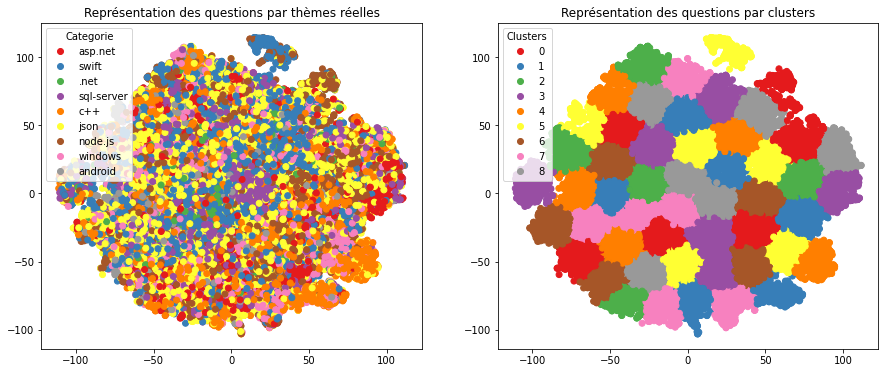

ARI :  0.0307


In [29]:
TSNE_visu_fct(X_tsne,y_cat_num,labels,ARI)

## BERT

In [17]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [18]:
max_length = 64
batch_size = 8
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df_clean['sentence_title_bow'].to_list()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-base-uncas

In [14]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/resol

1/1 [==============================] - 2s 2s/step


2022-08-13 14:19:48.967497: E tensorflow/core/framework/node_def_util.cc:630] NodeDef mentions attribute epsilon which is not in the op definition: Op<name=_MklFusedBatchMatMulV2; signature=x:T, y:T, args:num_args*T -> output:T; attr=T:type,allowed=[DT_BFLOAT16, DT_FLOAT]; attr=adj_x:bool,default=false; attr=adj_y:bool,default=false; attr=num_args:int,min=0; attr=fused_ops:list(string),default=[]> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node tf_bert_model_1/bert/encoder/layer_._0/attention/self/ArithmeticOptimizer/AddOpsRewrite_add_1}}


1/1 [==============================] - 0s 155ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 146ms/step


1/1 [==============================] - 0s 149ms/step


1/1 [==============================] - 0s 147ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 148ms/step
temps traitement :  2043.0


In [19]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.0143 time :  93.0


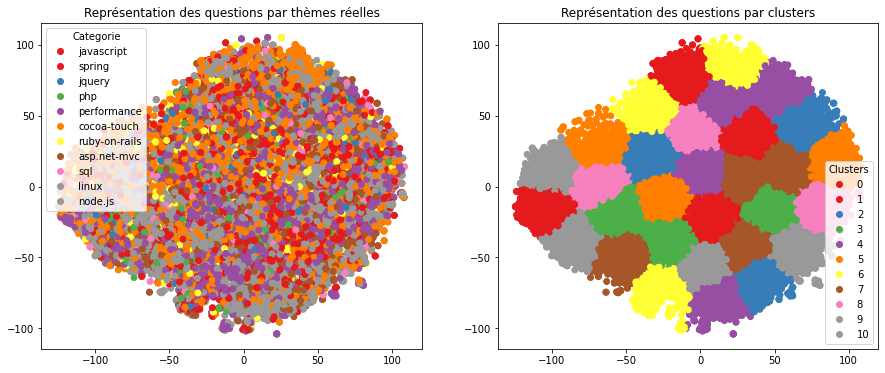

ARI :  0.0143


In [20]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## USE - Universal Sentence Encoder

In [30]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    return features

In [34]:
batch_size = 31
sentences = df_clean['sentence_title_bow'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)
len(features_USE)

27528

In [35]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0877 time :  83.0


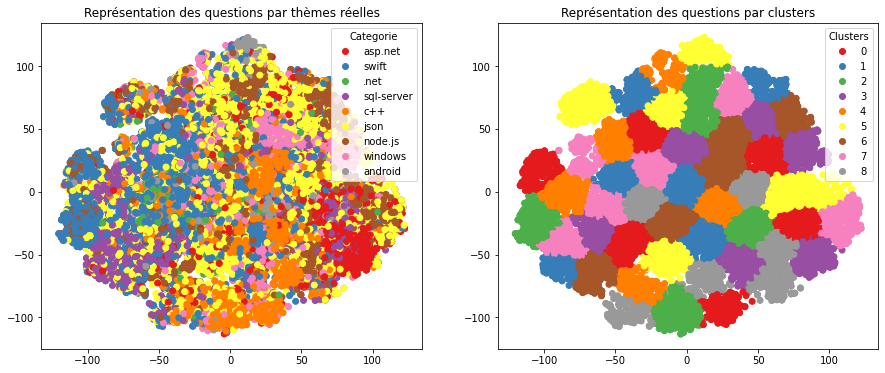

ARI :  0.0877


In [36]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Bert - 2ème tentative

In [13]:
NombreDeTags = 50
tags = [t[1:len(t) - 1].split('><') for t in df_clean['Tags']]
words = []
for t in tags:
     words += t
        
#print(len(words))
freq_totale = Counter(words)
mostcommon = np.array(freq_totale.most_common(NombreDeTags))

#removing the common words from tags
final_tags = []
for ts in tags:
    final_tags.append([word for word in ts if word in mostcommon])
final_tags = np.asarray(final_tags)
n = len(max(final_tags, key=len))
liste_2 = [x + [None]*(n-len(x)) for x in final_tags]
a = np.array(liste_2)
final_tags = pd.DataFrame(final_tags, dtype = object)
ftags = pd.DataFrame(a)
y = ftags.iloc[:,0]
#%%time
l_cat = list(set(y))
#print("catégories : ", l_cat)
y_cat_num = [(l_cat.index(ftags.iloc[i,0])) for i in range(len(ftags))]
ftags.head()

/tmp/ipykernel_987879/544698448.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_tags = np.asarray(final_tags)


,0,1,2,3,4
0,java,android,arrays,list,collections
1,language-agnostic,oop,immutability,setter,getter
2,c,file,directory,cross-platform,None
3,c#,.net,wcf,web-services,datatable
4,javascript,angularjs,selenium,selenium-webdriver,protractor


In [14]:
%%time
possible_labels = y.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
#label_dict

In [15]:
%%time
y= y.replace(label_dict)

In [16]:
%%time
X = df_clean.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
device = 'cpu'

In [228]:
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [25]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/fayz/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/fayz/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c3446

In [26]:
%%time
encoded_data_train = tokenizer.batch_encode_plus(
    X_train['sentence_title_bow'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt',
    truncation=True
)

In [27]:
%%time
encoded_data_val = tokenizer.batch_encode_plus(
    X_test['sentence_title_bow'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt',
    truncation=True
)

In [28]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [29]:
%%time
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21"

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/fayz/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequen

In [30]:
%%time
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 24

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [31]:
%%time
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-3, 
                  eps=1e-5)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [32]:
%%time
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [22]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [71]:
device = 'cpu'
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


    
for epoch in tqdm(range(1, epochs-1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/home/fayz/Documents/OpenClassrooms/Projet5/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/918 [00:00<?, ?it/s]


Epoch 1
Training loss: 3.6485413549252845
Validation loss: 3.7406244568202807
F1 Score (Weighted): 0.02101052205343798


Epoch 2:   0%|          | 0/918 [00:00<?, ?it/s]


Epoch 2
Training loss: 3.6796750030226697
Validation loss: 3.715570402145386
F1 Score (Weighted): 0.017149022258679873


Epoch 3:   0%|          | 0/918 [00:00<?, ?it/s]


Epoch 3
Training loss: 3.662601289146606
Validation loss: 3.729341173171997
F1 Score (Weighted): 0.02101052205343798


In [34]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/home/fayz/Documents/OpenClassrooms/Projet5/finetuned_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21"

loading weights file https://huggingface.co/bert-base-uncased/resolve/main/pytorch_model.bin from cache at /home/fayz/.cache/huggingface/transformers/a8041bf617d7f94ea26d15e218abd04afc2004805632abc0ed2066aa16d50d04.faf6ea826ae9c5867d12b22257f9877e6b8367890837bd60f7c54a29633f7f2f
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequen

Class: java
Accuracy: 594/594

Class: language-agnostic
Accuracy: 0/8

Class: c
Accuracy: 0/105

Class: c#
Accuracy: 0/522

Class: javascript
Accuracy: 0/534

Class: .net
Accuracy: 0/67

Class: php
Accuracy: 0/177

Class: sql-server
Accuracy: 0/10

Class: xcode
Accuracy: 0/16

Class: algorithm
Accuracy: 0/42

Class: c++
Accuracy: 0/336

Class: api
Accuracy: 0/4

Class: git
Accuracy: 0/45

Class: python
Accuracy: 0/588

Class: oop
Accuracy: 0/6

Class: r
Accuracy: 0/44

Class: asp.net
Accuracy: 0/53

Class: windows
Accuracy: 0/41

Class: svn
Accuracy: 0/1

Class: html
Accuracy: 0/89

Class: sql
Accuracy: 0/88

Class: android
Accuracy: 0/300

Class: memory-management
Accuracy: 0/1

Class: macos
Accuracy: 0/21

Class: performance
Accuracy: 0/21

Class: ruby-on-rails
Accuracy: 0/83

Class: ios
Accuracy: 0/358

Class: linux
Accuracy: 0/84

Class: database
Accuracy: 0/16

Class: emacs
Accuracy: 0/3

Class: encoding
Accuracy: 0/1

Class: internet-explorer
Accuracy: 0/3

Class: iphone
Accuracy

# Bert - 3ème implémentation

In [141]:
X = df_clean.copy()
NombreDeTags = 200
tags = [t[1:len(t) - 1].split('><') for t in df_clean['Tags']]
words = []
for t in tags:
     words += t
        
#print(len(words))
freq_totale = Counter(words)
mostcommon = np.array(freq_totale.most_common(NombreDeTags))

#removing the common words from tags
final_tags = []
for ts in tags:
    final_tags.append([word for word in ts if word in mostcommon])
final_tags = np.asarray(final_tags)
n = len(max(final_tags, key=len))
liste_2 = [x + [None]*(n-len(x)) for x in final_tags]
a = np.array(liste_2)
final_tags = pd.DataFrame(final_tags, dtype = object)
ftags = pd.DataFrame(a)
#y = ftags.iloc[:,0]
#%%time
#l_cat = list(set(y))
#print("catégories : ", l_cat)
#y_cat_num = [(l_cat.index(ftags.iloc[i,0])) for i in range(len(ftags))]
#ftags.head()

lst = freq_totale.most_common(NombreDeTags)
df_words = pd.DataFrame(lst, columns=['Word','Count'])
df_words = df_words.sort_values(by = 'Count',ascending=False)
labels = list(df_words['Word'])

for i in range(5):
    X.loc[:,f'Tags_{i+1}']=ftags.loc[:,i]

for i,j in enumerate(labels):
    X.loc[:,j] = 0
    
for i in range(len(X)):
    for j in range(5):
        X.loc[i,X.loc[:,f'Tags_{j+1}'][i]] = 1

X = X.drop(["Title","Tags","ViewCount"], axis = 1)

for j in range(5):
    X = X.drop([f'Tags_{j+1}'],axis = 1)

X = X.drop([None], axis =1)
X.head()

/tmp/ipykernel_1157946/4135302030.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  final_tags = np.asarray(final_tags)
/tmp/ipykernel_1157946/4135302030.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:,j] = 0
/tmp/ipykernel_1157946/4135302030.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  

,sentence_title_bow,python,java,javascript,c#,ios,android,c++,.net,iphone,...,facebook,colors,apache-spark-sql,cookies,loops,core-data,mvvm,dom,architecture,ssh
0,print array without brackets commas porting ha...,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,allen holub wrote you never use get set functi...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,how get directory listing how scan directory f...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,returning datatables wcf .net wcf service want...,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,element visible error able click element want ...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
target_list = labels

In [143]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [144]:
from transformers import BertTokenizer, BertModel

In [145]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /home/fayz/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /home/fayz/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c3446

In [146]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['sentence_title_bow']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index])
        }

In [147]:
train_size = 0.6
train_df = X
train_df = train_df.sample(frac=train_size, random_state=200).reset_index()
val_df = train_df.drop(['index'], axis = 1).reset_index(drop = True)

In [148]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [149]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [150]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [151]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [152]:
import shutil

In [153]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', problem_type="multi_label_classification",return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, NombreDeTags)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /home/fayz/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "transformers_version": "4.21.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-ba

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [154]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [155]:
val_targets=[]
val_outputs=[]

In [156]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

In [157]:
ckpt_path = f'/home/fayz/Documents/OpenClassrooms/Projet5/curr_ckpt'
best_model_path = f'/home/fayz/Documents/OpenClassrooms/Projet5/best_model.pt'

In [158]:
%%time
trained_model = train_model(EPOCHS, train_data_loader, val_data_loader, model, optimizer, ckpt_path, best_model_path)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000483 	Average Validation Loss: 0.000173
Validation loss decreased (inf --> 0.000173).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000145 	Average Validation Loss: 0.000123
Validation loss decreased (0.000173 --> 0.000123).  Saving model ...
############# Epoch 2  Done   #############

CPU times: user 1d 27min 37s, sys: 41min 12s, total: 1d 1h 8min 50s
Wall time: 3h 10min 20s


In [159]:
test_df = X_test

In [160]:
train_size = 0.1
test_df = X_test
test_df = test_df.sample(frac=train_size, random_state=200).reset_index(drop = True)
#test_df = test_df.drop(['index'], axis = 1)

In [161]:
test_df.loc[1,test_df.loc[1,:]==1]

php       1
linux     1
ubuntu    1
apache    1
email     1
Name: 1, dtype: object

In [162]:
for i in range(10):
    # testing
    example = test_df['sentence_title_bow'][i]
    encodings = tokenizer.encode_plus(
        example,
        None,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    trained_model.eval()
    with torch.no_grad():
        input_ids = encodings['input_ids'].to(device, dtype=torch.long)
        attention_mask = encodings['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = encodings['token_type_ids'].to(device, dtype=torch.long)
        output = trained_model(input_ids, attention_mask, token_type_ids)
        final_output = torch.sigmoid(output).cpu().detach().numpy().ravel().tolist()#.tolist()
        #print(train_df.columns[0:].to_list()[int(np.argmax(final_output, axis=1))])
        #print(final_output)
        dict_from_list = dict(zip(labels,final_output))
        print(list(sorted(dict_from_list.items(),key = lambda t : t[1]))[-4:])
        print(test_df.loc[i,test_df.loc[i,:]==1])
        print()
        print() 

[('javascript', 0.09103645384311676), ('c#', 0.09443885087966919), ('python', 0.10298149287700653), ('java', 0.10803687572479248)]
python         1
performance    1
string         1
list           1
Name: 0, dtype: object


[('javascript', 0.09126270562410355), ('c#', 0.09449228644371033), ('python', 0.1028783842921257), ('java', 0.1079355999827385)]
php       1
linux     1
ubuntu    1
apache    1
email     1
Name: 1, dtype: object


[('javascript', 0.0911778137087822), ('c#', 0.09444387257099152), ('python', 0.1029469221830368), ('java', 0.10795694589614868)]
javascript      1
asynchronous    1
angular         1
typescript      1
Name: 2, dtype: object


[('javascript', 0.09115922451019287), ('c#', 0.09450583904981613), ('python', 0.10289809852838516), ('java', 0.10802894830703735)]
c#             1
.net           1
performance    1
linq           1
Name: 3, dtype: object


[('javascript', 0.09136324375867844), ('c#', 0.09452419728040695), ('python', 0.10277746617794037), ('java', 0.1

In [163]:
print(list(sorted(dict_from_list.items(),key = lambda t : t[1]))[-4:])
print(test_df.loc[i,test_df.loc[i,:]==1])

[('javascript', 0.09128633141517639), ('c#', 0.09434353560209274), ('python', 0.10294289141893387), ('java', 0.10775690525770187)]
search    1
Name: 9, dtype: object


In [164]:
a = list(test_df.loc[4,test_df.loc[4,:]==1].index)
b = list(dict(sorted(dict_from_list.items(),key = lambda t : t[1])[-len(list(test_df.loc[4,test_df.loc[4,:]==1].index)):]).keys())

In [165]:
jaccard_score(a,b,average="macro")

0.0

In [166]:
for num in range(50):
    print(list(test_df.loc[num,test_df.loc[num,:]==1].index))
    print(list(dict(sorted(dict_from_list.items(),key = lambda t : t[1])[-len(list(test_df.loc[num,test_df.loc[num,:]==1].index)):]).keys()))
    a = list(test_df.loc[num,test_df.loc[num,:]==1].index)
    b = list(dict(sorted(dict_from_list.items(),key = lambda t : t[1])[-len(list(test_df.loc[num,test_df.loc[num,:]==1].index)):]).keys())
    print(len(set(a)&set(b))/len(a))
    print()

['python', 'performance', 'string', 'list']
['javascript', 'c#', 'python', 'java']
0.25

['php', 'linux', 'ubuntu', 'apache', 'email']
['ios', 'javascript', 'c#', 'python', 'java']
0.0

['javascript', 'asynchronous', 'angular', 'typescript']
['javascript', 'c#', 'python', 'java']
0.25

['c#', '.net', 'performance', 'linq']
['javascript', 'c#', 'python', 'java']
0.25

['java', 'spring', 'spring-boot', 'spring-mvc', 'spring-security']
['ios', 'javascript', 'c#', 'python', 'java']
0.2

['c++', 'c', 'gcc']
['c#', 'python', 'java']
0.0

['python', 'python-2.7', 'date']
['c#', 'python', 'java']
0.3333333333333333

['c#', '.net', 'performance', 'types', 'reflection']
['ios', 'javascript', 'c#', 'python', 'java']
0.2

['ios', 'iphone', 'uiwebview']
['c#', 'python', 'java']
0.0

['search']
['java']
0.0

['javascript', 'html', 'ios6', 'mobile-safari']
['javascript', 'c#', 'python', 'java']
0.25

['jquery', 'asp.net-mvc', 'post']
['c#', 'python', 'java']
0.0

['ruby-on-rails', 'ruby-on-rails-3', 